# <a id='toc1_'></a>[test area](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [test area](#toc1_)    
    - [load](#toc1_1_1_)    
  - [pls](#toc1_2_)    
    - [bars](#toc1_2_1_)    
    - [histo](#toc1_2_2_)    
    - [box](#toc1_2_3_)    
    - [pie](#toc1_2_4_)    
    - [join](#toc1_2_5_)    
    - [sankey](#toc1_2_6_)    
  - [tbl](#toc1_3_)    
    - [print_summary()](#toc1_3_1_)    
    - [describe_df()](#toc1_3_2_)    
    - [descr_db()](#toc1_3_3_)    
  - [show num](#toc1_4_)    
  - [venn](#toc1_5_)    
  - [hlp](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[load](#toc0_)

In [1]:
from pathlib import Path
import os
import seaborn as sb
import pandas as pd
import sys
import numpy as np
# from datetime import datetime
# from connection_helper import sql

from pandas_plots import tbl, pls, ven , hlp
import duckdb as ddb

hlp.show_package_version(["matplotlib_venn", "dataframe_image", "plotly", "kaleido", "seaborn"], )
df = sb.load_dataset('taxis')

# if os.getenv("RENDERER") in ('png', 'svg'):
#     os.environ['THEME'] = 'light'
# else:
#     os.environ['THEME'] = 'dark'

hlp.set_theme("dark")

dir_db=Path("C://temp") if hlp.get_os(hlp.OperatingSystem.WINDOWS) else Path(os.path.expanduser("~/tmp"))

file_db_clin = dir_db/'workflow/2025-06-24_data_clin.duckdb'

if not file_db_clin.is_file():
    print(f"File does not exist: {file_db_clin}")
    raise FileNotFoundError

print(hlp.get_os(hlp.OperatingSystem.MAC))

🐍 3.12.9 | 📦 matplotlib_venn: 0.11.10 | 📦 dataframe_image: 0.2.7 | 📦 plotly: 6.2.0 | 📦 kaleido: 1.0.0 | 📦 seaborn: 0.13.2 | 📦 pandas: 2.3.1 | 📦 numpy: 1.26.4 | 📦 duckdb: 1.3.2 | 📦 pandas-plots: 0.19.6 | 📦 connection-helper: 0.13.1
True


In [2]:
con = ddb.connect(file_db_clin, read_only=True)

In [3]:
db_delay = con.sql("""--sql
    select
            first(z_kkr_label) as z_kkr_label,
            first(z_first_treatment_after_days) as z_first_treatment_after_days, 
            first(z_first_treatment) as z_first_treatment
    from Tumor
    where ifnull(z_first_treatment,'') <> ''
    and z_dy = 2023 and z_icd10_3d = 'C81'
    group by z_tum_id
    """)

## <a id='toc1_2_'></a>[pls](#toc0_)

### <a id='toc1_2_1_'></a>[bars](#toc0_)

In [4]:
_ = pls.plot_bars(
    db_delay.to_df().iloc[:,:2],
    # height=400,
    # width=1000,
    # use_ci=True,
    # ci_agg='median',
)
_ = pls.plot_bars(
    db_delay.to_df().iloc[:,:2],
    height=600,
    use_ci=True,
    ci_agg='median',
)

In [5]:
_df = db_delay.filter("left(z_kkr_label,2)::int8 in (2,5,9,15)").to_df().iloc[:,[0,2,1]]
display(_df)
pls.plot_stacked_bars(
    _df,
    height=600,
    width=1600,
    orientation="h",
    relative=True,
    show_pct_bar=True,
    kkr_col="z_kkr_label",
    # renderer="png",
    )

,z_kkr_label,z_first_treatment,z_first_treatment_after_days
0,09-BY,sy,89
1,05-NW,sy,47
2,09-BY,sy,46
3,05-NW,op,0
4,05-NW,op,0
...,...,...,...
656,05-NW,sy,53
657,09-BY,sy,26
658,15-ST,sy,59
659,05-NW,sy,54


,z_dy,tu,z_kkr_label,cnt
0,2020,06,13-MV,1
1,2020,30,13-MV,1
2,2020,###,13-MV,21
3,2020,18,11-BE,1
4,2020,18.,13-MV,1
...,...,...,...,...
16352,2023,S37,14-SN,1
16353,2023,S72,11-BE,1
16354,2023,Z22,14-SN,1
16355,2023,Z85,14-SN,1


z_dy            int64
tu             object
z_kkr_label    object
cnt             int64
dtype: object


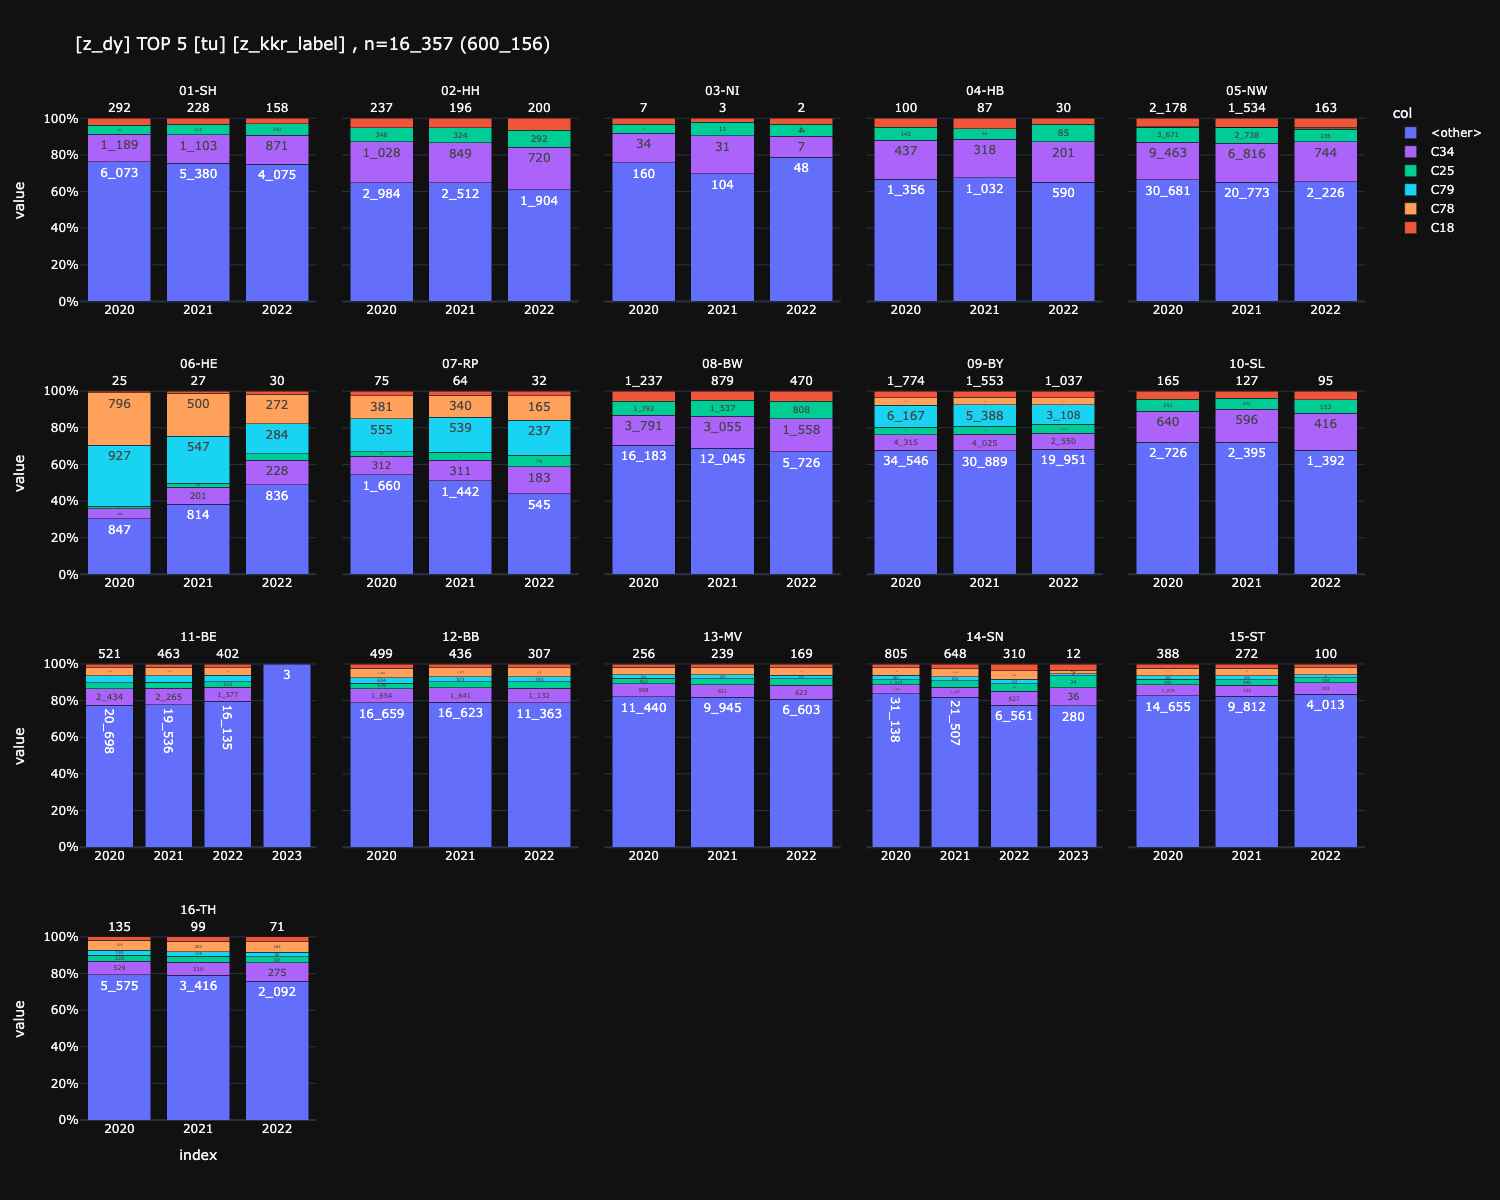

In [6]:
df_facets = pd.read_csv("assets/facets.csv", sep=";")#.astype({"z_dy": "Int64"}).astype({"z_dy": str})
display(df_facets[:None])
print(df_facets.dtypes)

_df = df_facets[
    [
        "z_dy",
        "tu",
        "z_kkr_label",
        "cnt",
    ]
]#[:100]
# _df


l=pls.plot_facet_stacked_bars(
    _df,
    top_n_color=5,
    # subplots_per_row=3,
    # top_n_facet=15,
    # top_n_index=3, 
    show_other=True,
    sort_values_color=True,
    # sort_values_facet=True,
    relative=True,
    # show_pct=True,
    annotations=True,
    subplot_size=300,
    subplots_per_row=5,
    # renderer="",
    # show_pct=True,
    )
# l

# ll = pls.plot_facet_stacked_bars(
#     _df,
#     top_n_color=5,
#     # subplots_per_row=8,
#     # top_n_facet=15,
#     # top_n_index=3, 
#     show_other=True,
#     sort_values_color=True,
#     # sort_values_facet=True,
#     relative=True,
#     annotations=True,
#     )
# # ll

### <a id='toc1_2_2_'></a>[histo](#toc0_)

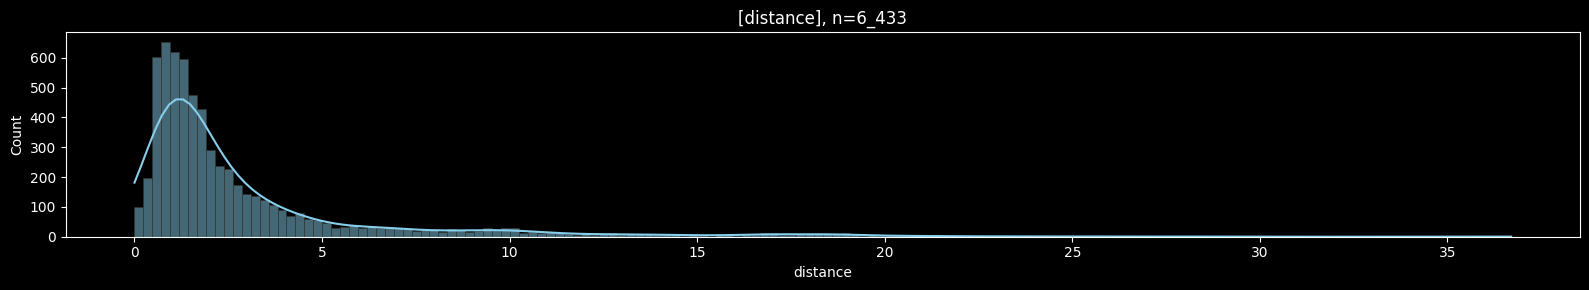


column   |   count   |  min  | lower |  q25  | median | mean  |  q75  | upper |  max   |  std  |  cv   |    sum     | skew  | kurto 
---------+-----------+-------+-------+-------+--------+-------+-------+-------+--------+-------+-------+------------+-------+-------
distance | 6_433.000 | 0.000 | 0.000 | 0.980 |  1.640 | 3.025 | 3.210 | 6.550 | 36.700 | 3.828 | 1.266 | 19_457.360 | 3.008 | 11.135



In [7]:
_=pls.plot_histogram_large(
    df.distance,
    # nbins=50,
    height=300,
    summary=True
)

In [8]:
# _df = df["distance"]
# # _df#.to_frame()
# # _df=df[["fare","distance"]]
# pls.plot_histogram(
#     _df,
#     height=300,
#     width=1000,
#     precision=0,
#     orientation="v",
#     histnorm="",
#     nbins=-1,
#     # barmode="overlay",
#     # renderer="png",
#     # png_path=Path(".local/box5.png"),
#     summary=True,
#     caption="test lol xd-lmao",
# )

### <a id='toc1_2_3_'></a>[box](#toc0_)

In [9]:
# _=pls.plot_box(
#     # df["distance"],
#     df[df["dropoff_borough"].isna()].distance,
#     height=200,
#     # violin=True,
#     # use_log=True,
# )

     dropoff_borough  distance
0          Manhattan      1.60
1          Manhattan      0.79
2          Manhattan      1.37
3          Manhattan      7.70
4          Manhattan      2.16
...              ...       ...
6428       Manhattan      0.75
6429           Bronx     18.74
6430        Brooklyn      4.14
6431        Brooklyn      1.12
6432        Brooklyn      3.85

[6433 rows x 2 columns]


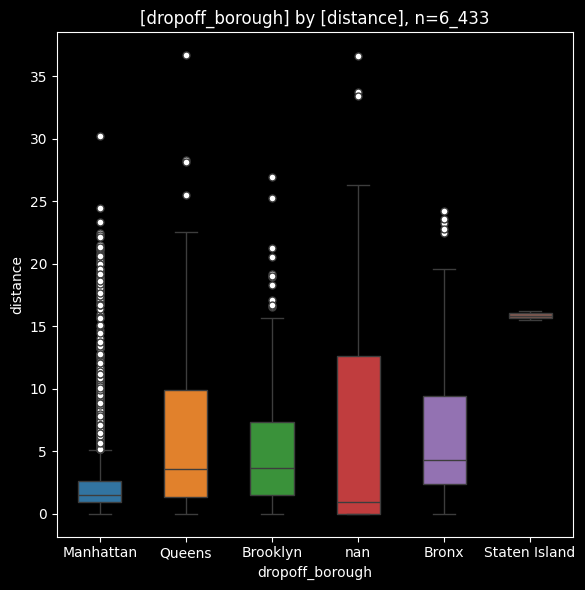


column   |  count   | min  | lower | q25  | median | mean | q75  | upper |  max  | std  |  cv  |    sum    | skew | kurto
---------+----------+------+-------+------+--------+------+------+-------+-------+------+------+-----------+------+------
distance | 6_433.00 | 0.00 |  0.00 | 0.98 |   1.64 | 3.02 | 3.21 |  6.55 | 36.70 | 3.83 | 1.27 | 19_457.36 | 3.01 | 11.13


column        |  count   |  min  | lower |  q25  | median | mean  |  q75  | upper |  max  |  std  |  cv  |    sum    | skew  | kurto
--------------+----------+-------+-------+-------+--------+-------+-------+-------+-------+-------+------+-----------+-------+------
Bronx         |   137.00 |  0.00 |  0.00 |  2.36 |   4.31 |  6.61 |  9.44 | 19.62 | 24.20 |  5.95 | 0.90 |    905.88 |  1.30 |  0.88
Brooklyn      |   501.00 |  0.00 |  0.00 |  1.53 |   3.63 |  5.03 |  7.30 | 15.70 | 26.92 |  4.49 | 0.89 |  2_519.28 |  1.42 |  2.23
Manhattan     | 5_206.00 |  0.00 |  0.00 |  0.91 |   1.50 |  2.39 |  2.60 |  5.13 | 30.23 |  2.91 |


column   |  count   | min  | lower | q25  | median | mean | q75  | upper |  max  | std  |  cv  |    sum    | skew | kurto
---------+----------+------+-------+------+--------+------+------+-------+-------+------+------+-----------+------+------
distance | 6_433.00 | 0.00 |  0.00 | 0.98 |   1.64 | 3.02 | 3.21 |  6.55 | 36.70 | 3.83 | 1.27 | 19_457.36 | 3.01 | 11.13


column        |  count   |  min  | lower |  q25  | median | mean  |  q75  | upper |  max  |  std  |  cv  |    sum    | skew  | kurto
--------------+----------+-------+-------+-------+--------+-------+-------+-------+-------+-------+------+-----------+-------+------
Bronx         |   137.00 |  0.00 |  0.00 |  2.36 |   4.31 |  6.61 |  9.44 | 19.62 | 24.20 |  5.95 | 0.90 |    905.88 |  1.30 |  0.88
Brooklyn      |   501.00 |  0.00 |  0.00 |  1.53 |   3.63 |  5.03 |  7.30 | 15.70 | 26.92 |  4.49 | 0.89 |  2_519.28 |  1.42 |  2.23
Manhattan     | 5_206.00 |  0.00 |  0.00 |  0.91 |   1.50 |  2.39 |  2.60 |  5.13 | 30.23 |  2.91 |

In [10]:
_df = df[["dropoff_borough","distance"]]
print(_df)
_=pls.plot_boxes_large(
    _df,
    width=600,
    # violin=True,
    # use_log=True,
)
_=pls.plot_boxes(
    _df,
    width=600,
    # violin=True,
    # use_log=True,
)


In [11]:
# pls.plot_box(
#     df.distance,
#     height=400,
#     violin=False,
#     x_min=-2,
#     x_max=50,
#     # summary = False
# )

# _df = df[["dropoff_borough", "distance"]]
# # _df["dropoff_borough"] = _df["dropoff_borough"].astype(str)
# display(_df.dtypes)
# display(_df)
# _=pls.plot_boxes(
#     _df,
#     width=1600,
#     annotations=False,
#     precision=4,
# )

### <a id='toc1_2_4_'></a>[pie](#toc0_)

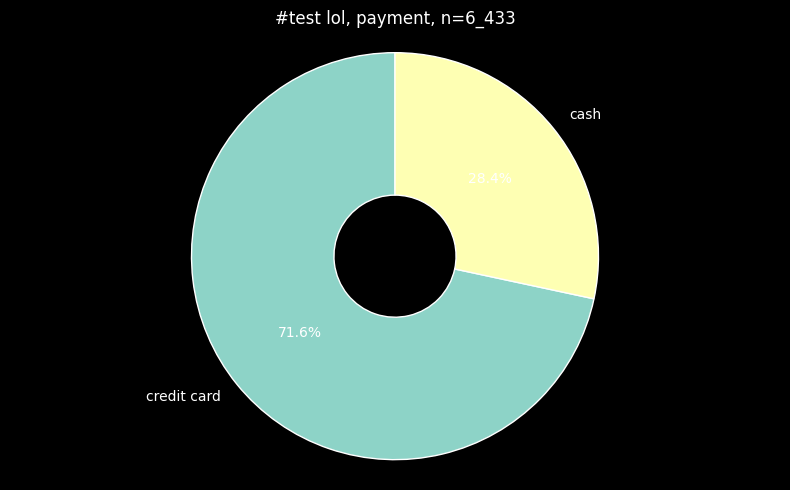

In [12]:
df["payment"]
pls.plot_pie(
    data=df["payment"],
    caption="test lol",
    donut_size=0.3,
    # precision=3,
)

### <a id='toc1_2_5_'></a>[join](#toc0_)

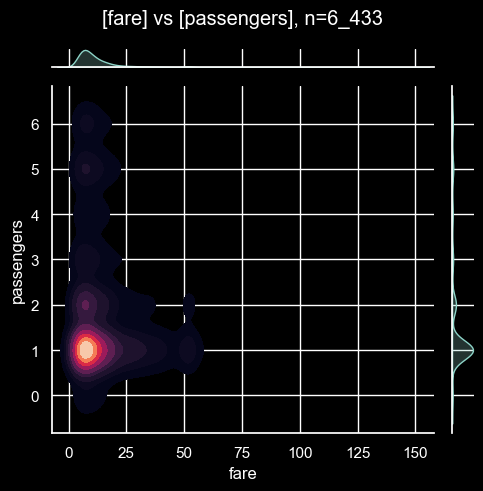

In [13]:
_df = df[["fare", "passengers"]]
# pls.plot_joint(_df, precision=0, size=15, kind="reg", caption="")
# pls.plot_joint(_df, precision=0, size=15, kind="hex", png_path=Path(".local/box6.png"))
pls.plot_joint(_df, precision=0, size=5, kind="kde",)
# pls.plot_joint(_df, precision=0, size=5, kind="hist",)
# pls.plot_joint(_df, precision=0, size=5, kind="kde", png_path=Path(".local/box7.png"))

### <a id='toc1_2_6_'></a>[sankey](#toc0_)

In [14]:
pls.plot_sankey(
    width=2000,
    font_size=15,
    # renderer="png",
)

--- Using demo data (data_demo) ---
   tumor-id diagnosis date treatment
0         1     2020-01-01        op
1         1     2021-02-01      syst
2         1     2022-03-01        op
3         1     2023-04-01       rad
4         1     2024-05-01        op
5         2     2010-01-01      syst
6         2     2011-02-01        st
7         2     2012-03-01        op
8         2     2013-04-01       rad
9         3     2015-01-01        op
10        3     2016-02-01       rad
11        3     2017-03-01      syst
12        3     2018-04-01        op
13        4     2005-01-01        st
14        4     2006-02-01      syst
15        4     2007-03-01        op
16        5     2019-01-01        op
17        5     2020-02-01       rad
18        6     2021-01-01      syst
19        6     2022-02-01        op
20        7                         
21        7                         
22        8     2025-01-01        op
23        9     2025-02-01        op
24       10     2025-03-01      syst
25

## <a id='toc1_3_'></a>[tbl](#toc0_)

### <a id='toc1_3_1_'></a>[print_summary()](#toc0_)

In [15]:
_=tbl.print_summary(df)


column     |   count   |  min  | lower |  q25   | median |  mean  |  q75   | upper  |   max   |  std   |  cv   |     sum     | skew  | kurto 
-----------+-----------+-------+-------+--------+--------+--------+--------+--------+---------+--------+-------+-------------+-------+-------
passengers | 6_433.000 | 0.000 | 0.000 |  1.000 |  1.000 |  1.539 |  2.000 |  3.000 |   6.000 |  1.204 | 0.782 |   9_902.000 | 2.359 |  4.881
distance   | 6_433.000 | 0.000 | 0.000 |  0.980 |  1.640 |  3.025 |  3.210 |  6.550 |  36.700 |  3.828 | 1.266 |  19_457.360 | 3.008 | 11.135
fare       | 6_433.000 | 1.000 | 1.000 |  6.500 |  9.500 | 13.091 | 15.000 | 27.540 | 150.000 | 11.552 | 0.882 |  84_214.870 | 3.217 | 17.649
tip        | 6_433.000 | 0.000 | 0.000 |  0.000 |  1.700 |  1.979 |  2.800 |  6.960 |  33.200 |  2.449 | 1.237 |  12_732.320 | 2.665 | 12.740
tolls      | 6_433.000 | 0.000 | 0.000 |  0.000 |  0.000 |  0.325 |  0.000 |  0.000 |  24.020 |  1.415 | 4.351 |   2_092.480 | 5.074 | 35.442
total

### <a id='toc1_3_2_'></a>[describe_df()](#toc0_)

In [16]:
df["lol"] = np.nan
df["lol"] = df["lol"].astype("float64")
tbl.describe_df(
    df,
    # "taxis",
    use_columns=False,
    # renderer="svg",
    top_n_uniques=10,
    top_n_chars_in_columns=10,
    top_n_chars_in_index=15,
)

🔵 *** df: <unknown> ***  
🟣 shape: (6_433, 15)
🟣 duplicates: 0  
🟠 column stats numeric  

column     |   count   |  min  | lower |  q25   | median |  mean  |  q75   | upper  |   max   |  std   |  cv   |     sum     | skew  | kurto 
-----------+-----------+-------+-------+--------+--------+--------+--------+--------+---------+--------+-------+-------------+-------+-------
passengers | 6_433.000 | 0.000 | 0.000 |  1.000 |  1.000 |  1.539 |  2.000 |  3.000 |   6.000 |  1.204 | 0.782 |   9_902.000 | 2.359 |  4.881
distance   | 6_433.000 | 0.000 | 0.000 |  0.980 |  1.640 |  3.025 |  3.210 |  6.550 |  36.700 |  3.828 | 1.266 |  19_457.360 | 3.008 | 11.135
fare       | 6_433.000 | 1.000 | 1.000 |  6.500 |  9.500 | 13.091 | 15.000 | 27.540 | 150.000 | 11.552 | 0.882 |  84_214.870 | 3.217 | 17.649
tip        | 6_433.000 | 0.000 | 0.000 |  0.000 |  1.700 |  1.979 |  2.800 |  6.960 |  33.200 |  2.449 | 1.237 |  12_732.320 | 2.665 | 12.740
tolls      | 6_433.000 | 0.000 | 0.000 |  0.000 |  0.000 

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough,lol
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan,NaN
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan,NaN
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan,NaN


### <a id='toc1_3_3_'></a>[descr_db()](#toc0_)

In [17]:
tbl.descr_db(db_delay, caption="delay", width=200)

🗄️ delay	1_687, 3
	("z_kkr_label, z_first_treatment_after_days, z_first_treatment")
┌─────────────┬──────────────────────────────┬───────────────────┐
│ z_kkr_label │ z_first_treatment_after_days │ z_first_treatment │
│   varchar   │            int32             │      varchar      │
├─────────────┼──────────────────────────────┼───────────────────┤
│ 03-NI       │                           26 │ sy                │
│ 02-HH       │                            0 │ op                │
│ 11-BE       │                           14 │ sy                │
└─────────────┴──────────────────────────────┴───────────────────┘

is_print: False


In [18]:
df_dsich = pd.read_csv("assets/dsich.csv", sep=";")#.astype({"z_dy": "Int64"}).astype({"z_dy": str})
display(df_dsich[:3])
# print(df_dsich.dtypes)

,id,bl,label,cnt
0,0,01-SH,7 - Histologie Primärtumor,14351
1,22,01-SH,3 - Todesbescheinigung (DCO),1004
2,23,01-SH,5 - Zytologie,146


In [19]:
_df = df_dsich[
    [
        "bl",
        "label",
        "cnt",
    ]
].sort_values("bl")

_ = pls.plot_stacked_bars(
    _df,
    # swap=True,
    orientation="h",
    # show_total=True,
    # normalize=True,
    # relative=True,
    height=600,
    # top_n_color=5,
    # sort_values_index=True,
    sort_values_color=True,
    # top_n_index=3,
    # precision=2,
    # show_other=True,
    # top_n_index=2,
    kkr_col="bl",
)
_

In [20]:
_df = df_facets[
    [
        "z_kkr_label",
        "z_dy",
        "cnt",
    ]
]#.astype({"z_dy": str})

_ = pls.plot_stacked_bars(
    _df,
    # swap=True,
    orientation="h",
    # show_total=True,
    # normalize=True,
    # relative=True,
    height=1000,
    top_n_color=10,
    # sort_values_index=True,
    # sort_values_color=True,
    # top_n_index=5,
    # precision=2,
    # show_other=True,
    # top_n_index=2,
    # renderer="png",
)
_

In [21]:
_df = df_facets[
    [
        "z_kkr_label",
        "cnt",
    ]
]
_df

_ = pls.plot_bars(
    _df,
    height=600,
    width=1200,
    sort_values=True,
    # renderer="png",
)

In [22]:
_df = df[["color","payment","pickup_borough","total"]]
_df
# _=pls.plot_stacked_bars(_df[["color","payment","total"]],)
tbl.describe_df(_df, "taxis")

🔵 *** df: taxis ***  
🟣 shape: (6_433, 4)
🟣 duplicates: 4_803  
🟠 column stats all (dtype | uniques | missings) [values]  
- index [0, 1, 2, 3, 4,]  
- color (object | 2 | 0 (0%)) ['green', 'yellow',]  
- payment (object | 3 | 44 (1%)) ['<NA>', 'cash', 'credit card',]  
- pickup_borough (object | 5 | 26 (0%)) ['<NA>', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens',]  
- total (float64 | 898 | 0 (0%)) [1.3, 3.3, 3.31, 3.8, 4.3,]  
🟠 column stats numeric  

column |   count   |  min  | lower |  q25   | median |  mean  |  q75   | upper  |   max   |  std   |  cv   |     sum     | skew  | kurto 
-------+-----------+-------+-------+--------+--------+--------+--------+--------+---------+--------+-------+-------------+-------+-------
total  | 6_433.000 | 1.300 | 1.300 | 10.800 | 14.160 | 18.518 | 20.300 | 34.550 | 174.820 | 13.816 | 0.746 | 119_124.970 | 3.093 | 15.053



,color,payment,pickup_borough,total
0,yellow,credit card,Manhattan,12.95
1,yellow,cash,Manhattan,9.30
2,yellow,credit card,Manhattan,14.16


In [23]:
db = con.from_df(df)
tbl.descr_db(db, caption="taxis",)

🗄️ taxis	6_433, 15
	("pickup, dropoff, passengers, distance, fare, tip, tolls, total, color, payment, pickup_zone, dropoff_zone, pickup_borough, dropoff_borough, lol")
┌─────────────────────┬─────────────────────┬────────────┬──────────┬────────┬────────┬────────┬────────┬─────────┬─────────────┬───────────────────────┬───────────────────────┬────────────────┬─────────────────┬────────┐
│       pickup        │       dropoff       │ passengers │ distance │  fare  │  tip   │ tolls  │ total  │  color  │   payment   │      pickup_zone      │     dropoff_zone      │ pickup_borough │ dropoff_borough │  lol   │
│    timestamp_ns     │    timestamp_ns     │   int64    │  double  │ double │ double │ double │ double │ varchar │   varchar   │        varchar        │        varchar        │    varchar     │     varchar     │ double │
├─────────────────────┼─────────────────────┼────────────┼──────────┼────────┼────────┼────────┼────────┼─────────┼─────────────┼───────────────────────┼─────────────

## <a id='toc1_4_'></a>[show num](#toc0_)

In [24]:
from pathlib import Path

_df=df.pivot_table(index="color", columns="payment", values="fare", aggfunc="sum", dropna=False)
tbl.show_num_df(
    _df,
    total_mode="sum",
    total_axis="y",
    data_bar_axis="",
    pct_axis="xy",
    precision=0,
    heatmap_axis="xy",
    # kpi_mode="max_min_x",
    total_exclude=True,
    # kpi_mode="min_max_xy",
    kpi_mode="rag_abs",
    kpi_rag_list=(100, 1000),
    # swap=True,
    font_size_td=12,
    font_size_th=14,
    # png_path=Path("test.png"),
)

payment,cash,credit card,nan,Total
color,,,,
green,3_995 (4.7%) 🟥,9_774 (11.6%) 🟥,20 (0.0%) 🟩,13_788 (16.4%) 🟥
yellow,17_012 (20.2%) 🟥,52_907 (62.8%) 🟥,508 (0.6%) 🟨,70_427 (83.6%) 🟥


In [25]:
_df=df[["color", "payment", "fare"]]
tbl.pivot_df(
    _df,
    total_mode="sum",
    data_bar_axis="xy",
    pct_axis="xy",
    precision=0,
    heatmap_axis="",
    kpi_mode="max_min_x"
    # kpi_mode="min_max_xy",
    # kpi_mode="rag_abs",
    # kpi_rag_list=(100, 1000),
)

payment,nan,cash,credit card,Total
color,,,,
green,20 (0.0%) 🟥,3_995 (4.7%) 🟥,9_774 (11.6%) 🟥,13_788 (16.4%) 🟥
yellow,508 (0.6%) 🟩,17_012 (20.2%) 🟩,52_907 (62.8%) 🟩,70_427 (83.6%) 🟩
Total,528 (0.6%) ⬛,21_006 (24.9%) ⬛,62_681 (74.4%) ⬛,84_215 (100.0%) ⬛


In [26]:
_df = df[["distance", "fare", "tip", "tolls"]][:5]
tbl.show_num_df(
    _df,
    data_bar_axis="x",
    pct_axis="xy",
    precision=3,
    total_mode="sum",
)
# _df['distance'].mean()

,distance,fare,tip,tolls,Total
0,1.600 (2.0%),7.000 (8.7%),2.150 (2.7%),0,10.750 (13.3%)
1,0.790 (1.0%),5.000 (6.2%),0,0,5.790 (7.2%)
2,1.370 (1.7%),7.500 (9.3%),2.360 (2.9%),0,11.230 (13.9%)
3,7.700 (9.5%),27.000 (33.4%),6.150 (7.6%),0,40.850 (50.5%)
4,2.160 (2.7%),9.000 (11.1%),1.100 (1.4%),0,12.260 (15.2%)
Total,13.620 (16.8%),55.500 (68.6%),11.760 (14.5%),0,80.880 (100.0%)


## <a id='toc1_5_'></a>[venn](#toc0_)

ab --> cars1 | cars2 --> len: 7


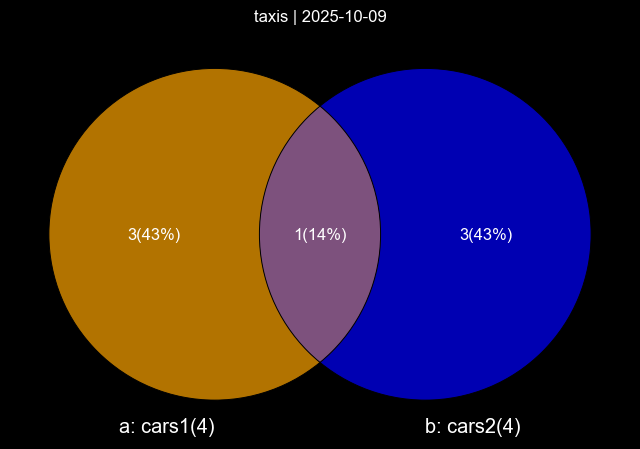

In [27]:
set_a = {'ford','ferrari','mercedes', 'bmw'}
set_b = {'opel','bmw','bentley','audi'}
_df, _details = ven.show_venn2(
    title="taxis",
    a_set=set_a,
    a_label="cars1",
    b_set=set_b,
    b_label="cars2",
    verbose=0,
    size=8,
)

abc --> cars1 | cars2 | cars3 --> len: 11
ab --> cars1 | cars2 --> len: 7
ac --> cars1 | cars3 --> len: 8
bc --> cars2 | cars3 --> len: 9


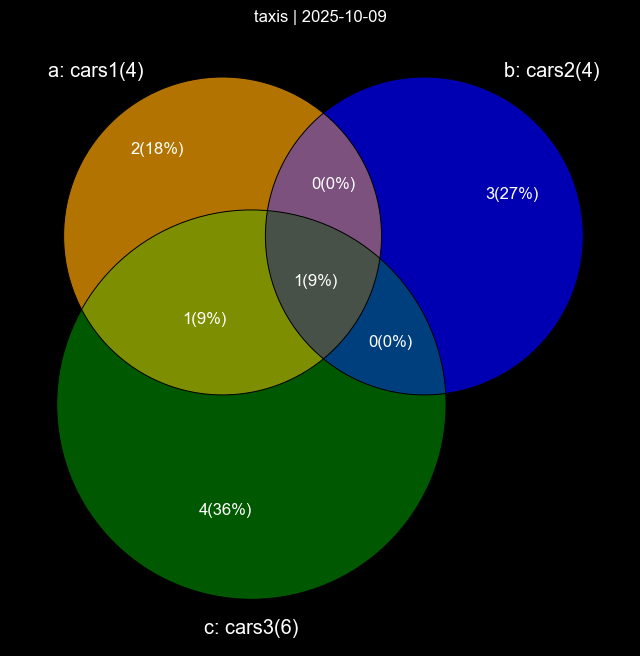

In [28]:
set_a = {'ford','ferrari','mercedes', 'bmw'}
set_b = {'opel','bmw','bentley','audi'}
set_c = {'ferrari','bmw','chrysler','renault','peugeot','fiat'}
_df, _details = ven.show_venn3(
    title="taxis",
    a_set=set_a,
    a_label="cars1",
    b_set=set_b,
    b_label="cars2",
    c_set=set_c,
    c_label="cars3",
    verbose=0,
    size=8,
)

## <a id='toc1_6_'></a>[hlp](#toc0_)

In [29]:
df.pickup.to_series()

0      2019-03-23 20:21:09
1      2019-03-04 16:11:55
2      2019-03-27 17:53:01
3      2019-03-10 01:23:59
4      2019-03-30 13:27:42
               ...        
6428   2019-03-31 09:51:53
6429   2019-03-31 17:38:00
6430   2019-03-23 22:55:18
6431   2019-03-04 10:09:25
6432   2019-03-13 19:31:22
Name: pickup, Length: 6433, dtype: datetime64[ns]

In [30]:
hlp.get_tum_details("df6bc655-e0ca-47f1-900c-ff2c749b3c7d", con)

pat
┌──────────────────────────────────────┬─────────┬────────┬─────────┬────────────┬──────────────┬──────────────────────────┬──────────────────┬──────────────────────────────┐
│               z_pat_id               │  z_sex  │ z_age  │ z_ag05  │ Verstorben │ Geburtsdatum │ Geburtsdatum_Genauigkeit │ DatumVitalStatus │ DatumVitalStatus_Genauigkeit │
│               varchar                │ varchar │ double │ varchar │  varchar   │     date     │         varchar          │       date       │           varchar            │
├──────────────────────────────────────┼─────────┼────────┼─────────┼────────────┼──────────────┼──────────────────────────┼──────────────────┼──────────────────────────────┤
│ 450b0462-3c82-411a-ab33-9ed13286a58d │ W       │  83.25 │ a80b84  │ N          │ 1939-12-15   │ T                        │ 2023-06-15       │ T                            │
└──────────────────────────────────────┴─────────┴────────┴─────────┴────────────┴──────────────┴────────────────────────

In [31]:
hlp.add_measures_to_pyg_config(".local/pygwalker_spec_.json", strict=False)

In [32]:
from pandas_plots import hlp
url="https://github.com/robert-koch-institut/Bundesweiter_klinischer_Krebsregisterdatensatz-Datenschema_und_Klassifikationen"
# url="http://google.com"

# hlp.create_barcode_from_url(
#     url=url,
#     output_path=".local/zfkd-repo.png",
#     show_image=True,
# )

In [33]:
hlp.find_cols(df, [
    "Tot",
    "DIS",
    ])


['total', 'distance']

In [34]:
# df
# from pandas_plots import hlp
hlp.add_datetime_columns(df,"dropoff")
# df

⏳ Adding datetime columns basing off of: dropoff


,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,...,pickup_borough,dropoff_borough,lol,YYYY,MM,Q,YYYY-MM,YYYYQ,YYYY-WW,DDD
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,...,Manhattan,Manhattan,NaN,2019,3,1,2019-03,2019Q1,2019-W12,Sat
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,...,Manhattan,Manhattan,NaN,2019,3,1,2019-03,2019Q1,2019-W10,Mon
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,...,Manhattan,Manhattan,NaN,2019,3,1,2019-03,2019Q1,2019-W13,Wed
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,...,Manhattan,Manhattan,NaN,2019,3,1,2019-03,2019Q1,2019-W10,Sun
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,...,Manhattan,Manhattan,NaN,2019,3,1,2019-03,2019Q1,2019-W13,Sat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6428,2019-03-31 09:51:53,2019-03-31 09:55:27,1,0.75,4.5,1.06,0.0,6.36,green,credit card,...,Manhattan,Manhattan,NaN,2019,3,1,2019-03,2019Q1,2019-W13,Sun
6429,2019-03-31 17:38:00,2019-03-31 18:34:23,1,18.74,58.0,0.00,0.0,58.80,green,credit card,...,Queens,Bronx,NaN,2019,3,1,2019-03,2019Q1,2019-W13,Sun
6430,2019-03-23 22:55:18,2019-03-23 23:14:25,1,4.14,16.0,0.00,0.0,17.30,green,cash,...,Brooklyn,Brooklyn,NaN,2019,3,1,2019-03,2019Q1,2019-W12,Sat
6431,2019-03-04 10:09:25,2019-03-04 10:14:29,1,1.12,6.0,0.00,0.0,6.80,green,credit card,...,Brooklyn,Brooklyn,NaN,2019,3,1,2019-03,2019Q1,2019-W10,Mon


In [35]:
lol="""
The most important themes of the draft referendum are:
1. Improving the use of health data for research and innovation, particularly through the establishment of a National Data Access Point;
2. Enhancing the coordination and networking of different stakeholders involved in health data management;
3. Expanding the scope of the General Data Protection Regulation (GDPR) to cover all areas of healthcare;
4. Providing better access to health data for patients and researchers, including through the development of a new law on health data protection;
5. Facilitating the exchange of health data between different countries and regions, particularly within the European Union (EU);
6. Ensuring that data are used in a way that promotes sustainable development and achieves the United Nations' Sustainable Development Goals (SDGs)."""

print(
hlp.wrap_text(
    text=lol,
    # max_items_in_line=40,
    use_sep=True,
    use_apo=True,
)
)

[The most important themes of the draft referendum are:  
1. Improving the use of health data for research and innovation particularly through  
the establishment of a National Data Access Point;  
2. Enhancing the coordination and networking of different stakeholders involved  
in health data management;  
3. Expanding the scope of the General Data Protection Regulation (GDPR) to cover all  
areas of healthcare;  
4. Providing better access to health data for patients and researchers including through  
the development of a new law on health data protection;  
5. Facilitating the exchange of health data between different countries and regions  
particularly within the European Union (EU);  
6. Ensuring that data are used in a way that promotes sustainable development and achieves  
the United Nations Sustainable Development Goals (SDGs).]
